In [1]:
import pickle
from distutils.dir_util import copy_tree
with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/extra_scripts/src.py') as f:
    exec(f.read())
torch.manual_seed(1)

np.random.seed(1)
random.seed(1)
import numpy as np
import scipy.stats as st
import scanpy as sc
from copy import deepcopy
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/jislam/.local/lib/python3.10/site-packages/gosip/__init__.py:5: FutureWarning: In the future `np.ulong` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'ulong'):


In [2]:
sns.set(style="whitegrid")
#torch.use_deterministic_algorithms(False)
main_path="/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/"
dataLocation="/home/jislam/Documents/gits/pancdb/T1D_T2D_public.h5ad"
single_cell_data="nbonlyrealistic_simulation_alpha_to_beta"
filter_by="cell_type"
categories_to_keep = 7 #number of cell types I want to keep in the model sorted by decreasing cell count, can use all but only so much weighted losses can do...
 # See adata.obs.columns for what categories you can use here. Specify which columns to one-hot-encode and use to inform the models. cell_disease is generated for the interaction.
category_labels=["cell_disease","sex"]
#MUST BE SPECIFIED FOR EACH INQUIRY. SEE BOTTOM OF SCRIPT. NEAR THE BOTTOM: when generating the full reports, you will need to specify the following parameters manually. For example.
#shared_filter = ["sex=female"] # EXACT LABEL in adata.one_hot_encoded.columns. If set to None, will not filter. if you want to specify a particular subset of cells, not of the criteria of interest (in this case sex, or race would make sense if cell_disease is what I'm interested in)
#filter_criteria_start = ["T2D"]# SMART LABEL: searches for the substring in adata.one_hot_encoded.columns. can grab all T2D with "T2D" or the specific interaction with ->["cell_disease=alpha cell_Control"] #
#filter_criteria_goal =["Control"]#SMART LABEL: same idea. ["cell_disease=beta cell_Control"]
#THESE FILTERS SHOULD BE SPECIFIED FOR EACH INQUIRY. See bottom of script.
min_optuna=10
hyperparam_epochs=100 #max per trial
hyperparam_trials=100 #number of trials for each model.
patience=5
burn_in=10
num_epochs=1000



zi=False

runs=100
bsize=1024
####################################

validation_ratio=0.2 #10% of dataset is kept for validation during training. we do not use a testing set since we're only interested in what it learned not generalizability.


sns.set(style="whitegrid")

validation_ratio=0.1


outdir=single_cell_data.replace(" ", "_")
if not os.path.exists(outdir):
    os.makedirs(outdir)





adata=sc.read_h5ad(dataLocation)
adata=adata[adata.obs["disease_state"]!="AAB"]
adata=adata[adata.obs["disease_state"]!="T1D"]
adata=adata[adata.obs["cell_type"]!="unknown"]
adata=adata[adata.obs["sex"]=="male"]
adata.obs["cell_disease"]=adata.obs["cell_type"].astype(str) + '_' + adata.obs["disease_state"].astype(str)
selected_labels=adata.obs[filter_by].value_counts().index.to_list()[0:categories_to_keep]
adata=gosip.filter_adata_by_labels(adata,selected_labels=selected_labels,column_name=filter_by)
print("begin preprocessing...")
print("filtering...")
#sc.pp.filter_cells(adata, min_genes=100)
#sc.pp.filter_genes(adata, min_cells=3)
filter_criteria_start = ["cell_disease=alpha cell_Control"] #["T2D"]#
filter_criteria_goal =["cell_disease=beta cell_Control"] # ["Control"]# 


states = adata[(adata.obs['cell_disease'] == "alpha cell_Control") | (adata.obs['cell_disease'] == "beta cell_Control")].copy()
sc.pp.filter_cells(states, min_genes=100)
sc.pp.filter_genes(states, min_cells=3)
start_state=states[states.obs['cell_disease']=="alpha cell_Control"].copy()
start_state.X=start_state.X.toarray()
goal_state=states[states.obs['cell_disease']=="beta cell_Control"].copy()
goal_state.X=goal_state.X.toarray()


def preprocess_data(adata, top_p_genes=500):
    """
    Preprocesses the data by calculating the mean, variance, dispersion, zero percentages,
    and the correlation matrix for top p highly variable genes.
    
    Parameters:
    - adata: AnnData object containing the original single-cell data.
    - top_p_genes: Number of highly variable genes to consider for correlation structure.
    
    Returns:
    - preprocessed_data: Dictionary containing preprocessed statistics:
        - 'mean_expr': Array of mean expression values for each gene.
        - 'var_expr': Array of variance values for each gene.
        - 'dispersion': Array of dispersion values for each gene.
        - 'zero_percentages': List of expected percentage of zeros for each gene.
        - 'top_genes_corr_matrix': Correlation matrix for top p highly variable genes.
        - 'top_genes_indices': Indices of top p highly variable genes.
    """
    count_matrix = adata.X
    n_genes = adata.n_vars
    n_cells = adata.n_obs
    print("step 1")
    # Step 1: Replace zero entries with the median of non-zero values for each gene
    modified_matrix = count_matrix.copy()
    for i in range(n_genes):
        non_zero_values = modified_matrix[modified_matrix[:, i] > 0, i]
        median_non_zero = np.mean(non_zero_values) if non_zero_values.size > 0 else 0
        modified_matrix[modified_matrix[:, i] == 0, i] = median_non_zero
    print("step 2")
    # Step 2: Compute mean, variance, and dispersion
    mean_expr = np.mean(modified_matrix, axis=0)
    var_expr = np.var(modified_matrix, axis=0)
    dispersion = np.maximum(var_expr / mean_expr, 1e-8)  # Avoid division by zero
    print("step 3")
    # Step 3: Calculate percentage of zeros
    #scaling_factor = 0.5  # Controls dropout adjustment based on mean expression
    # Define a scaling factor to control the dropout effect (adjust this based on your needs)
    scaling_factor = 1.0
    # Calculate dropout probabilities inversely with mean expression
    adjusted_dropout_probs = (1 / (1 + scaling_factor * mean_expr))
    adjusted_dropout_probs = adjusted_dropout_probs / adjusted_dropout_probs.sum()

    # Step 4: Identify top p highly variable genes
    top_genes_indices = np.argsort(var_expr)[-top_p_genes:]
    print("step 5 calculate correlations")
    # Step 5: Calculate gene-gene correlation matrix for top genes
    top_genes_matrix = modified_matrix[:, top_genes_indices]
    normalized_data = np.log1p(top_genes_matrix)
    top_genes_corr_matrix = np.corrcoef(normalized_data.T)

    # Pack everything into a dictionary
    preprocessed_data = {
        'mean_expr': mean_expr,
        'var_expr': var_expr,
        'dispersion': dispersion,
        'zero_percentages': adjusted_dropout_probs,
        'top_genes_corr_matrix': top_genes_corr_matrix,
        'top_genes_indices': top_genes_indices,
        'modified_matrix':sc.AnnData(X=modified_matrix)
    }
    
    return preprocessed_data
def convert_params(mean, var):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://mathworld.wolfram.com/NegativeBinomialDistribution.html
    """

    n=mean**2/(var-mean)
    p = mean/var
    #print(n,p)
    return n, p
def simulate_correlated_counts_with_median(preprocessed_data, n_cells_simulated):
    """
    Simulates correlated single-cell count data using precomputed statistics.
    
    Parameters:
    - preprocessed_data: Dictionary containing precomputed statistics:
        - 'mean_expr': Array of mean expression values for each gene.
        - 'dispersion': Array of dispersion values for each gene.
        - 'top_genes_corr_matrix': Correlation matrix for top p highly variable genes.
        - 'top_genes_indices': Indices of top p highly variable genes.
    - n_cells_simulated: Number of cells to simulate.
    
    Returns:
    - sim_adata: AnnData object with simulated count data.
    """
    mean_expr = preprocessed_data['mean_expr'].copy()
    var_expr = preprocessed_data['var_expr'].copy()
    #dispersion = preprocessed_data['dispersion'].copy()
    correlation_matrix = preprocessed_data['top_genes_corr_matrix'].copy()
    top_genes_indices = preprocessed_data['top_genes_indices'].copy()
    n_genes = len(mean_expr)

    # Step 6: Simulate data for highly variable genes with correlation structure
    mvnorm_data = np.random.multivariate_normal(np.zeros(len(top_genes_indices)), correlation_matrix, size=n_cells_simulated)
    uniform_data_top_genes = st.norm.cdf(mvnorm_data)

    simulated_counts = np.zeros((n_cells_simulated, n_genes))



    # Generate counts for highly variable genes, preserving correlation
    for idx, gene_idx in enumerate(top_genes_indices):
        mu, var = mean_expr[gene_idx], var_expr[gene_idx]
        # Check if p equals 1, which implies a mean of zero counts
        if var > mu :
            n,p=convert_params(mu, var)
            simulated_counts[:, gene_idx] = st.nbinom.ppf(uniform_data_top_genes[:, idx], n, p)
        else:
            #clear_output(wait=True)
            #print("skip"+ str(gene_idx))
            simulated_counts[:, gene_idx] = st.poisson.ppf(uniform_data_top_genes[:, idx],mu)

    # Generate independent counts for remaining genes
    remaining_genes = set(range(n_genes)) - set(top_genes_indices)
    for gene_idx in remaining_genes:
        mu, var = mean_expr[gene_idx], var_expr[gene_idx]                
        if var > mu :
            n,p=convert_params(mu, var)
            simulated_counts[:, gene_idx] = st.nbinom.rvs(n, p, size=n_cells_simulated)
            #simulated_counts[:, gene_idx] = st.nbinom.ppf(uniform_data_top_genes[:, idx], n, p)
        else:
            simulated_counts[:, gene_idx] = np.random.poisson(mu, size=n_cells_simulated)
            # If p = 1, leave the column as zeros
            #clear_output(wait=True)
            #print("skip"+ str(gene_idx))
            

    # Return simulated data as an AnnData object
    sim_adata = sc.AnnData(X=simulated_counts)
    
    return sim_adata#,sim_adata[:,top_genes_indices]


/tmp/ipykernel_317539/1154160513.py:51: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cell_disease"]=adata.obs["cell_type"].astype(str) + '_' + adata.obs["disease_state"].astype(str)


begin preprocessing...
filtering...


In [3]:

# Example usage
preprocessed_start = preprocess_data(start_state.copy(), top_p_genes=500)


preprocessed_goal = preprocess_data(goal_state.copy(), top_p_genes=500)


step 1
step 2


/tmp/ipykernel_317539/1154160513.py:103: RuntimeWarning: invalid value encountered in divide
  dispersion = np.maximum(var_expr / mean_expr, 1e-8)  # Avoid division by zero


step 3
step 5 calculate correlations
step 1
step 2
step 3
step 5 calculate correlations


/tmp/ipykernel_317539/1154160513.py:103: RuntimeWarning: invalid value encountered in divide
  dispersion = np.maximum(var_expr / mean_expr, 1e-8)  # Avoid division by zero


In [4]:
# Find common genes
import numpy as np
import scanpy as sc

def apply_cellwise_dropout(adata, dropout_percentage, gene_dropout_probs):
    """
    Apply dropout to each cell based on a given dropout percentage and gene-specific dropout probabilities.

    Parameters:
    - adata: AnnData object
    - dropout_percentage: Percentage (float) of genes to randomly drop per cell
    - gene_dropout_probs: Array of dropout probabilities per gene (length = number of genes)

    Returns:
    - Modified AnnData object with dropout applied
    """
    if dropout_percentage>0:
        # Ensure dropout_percentage is a valid number between 0 and 100
        if not (0 <= dropout_percentage <= 1):
            raise ValueError("dropout_percentage must be between 0 and 100.")
        
        # Ensure gene_dropout_probs has the correct shape (same number of genes as adata.X)
        if len(gene_dropout_probs) != adata.X.shape[1]:
            raise ValueError("gene_dropout_probs length must match the number of genes in the dataset.")
        
        # Normalize gene_dropout_probs to make sure they sum to 1 (probabilities)
        num_genes_to_dropout = int(adata.X.shape[1] * dropout_percentage )
        # Loop through each cell
        
        for cell_idx in range(adata.X.shape[0]):
            # Calculate how many genes to drop for this cell based on dropout_percentage
            
            
            # For this cell, sample which genes to drop based on the gene-specific probabilities
            genes_to_drop = np.random.choice(adata.X.shape[1], num_genes_to_dropout, replace=False, p=gene_dropout_probs)

            #clear_output()
            #print(len(genes_to_drop))
            # Set the values of the selected genes to zero in this cell
            adata.X[cell_idx, genes_to_drop] = 0
    return adata

def merge_adata(adata1,param1,adata2,param2,dropout_percentage):
    adata1=adata1.copy()
    adata2=adata2.copy()
    #adata1=apply_cellwise_dropout(adata1, dropout_percentage, param1['zero_percentages'])
    #adata2=apply_cellwise_dropout(adata2, dropout_percentage, param2['zero_percentages'])
    common_genes = adata1.var.index.intersection(adata2.var.index)
    
    # Subset both adatas to only keep common genes and reorder columns (genes)
    adata1 = adata1[:, common_genes]
    adata2 = adata2[:, common_genes]
    
    adata_combined = sc.concat([adata1, adata2], join='inner', label='batch')
    return adata_combined



In [5]:

import numpy as np

def compare_adata_properties(start_state, sim_start, tolerance=1e-2):
    """
    Compares the mean, variance, dispersion, and zero percentage for each gene
    in two AnnData objects, `start_state` and `sim_start`.
    
    Parameters:
    - start_state: AnnData object representing the original data.
    - sim_start: AnnData object representing the simulated data.
    - tolerance: float, optional. Tolerance level for reporting differences.
    
    Prints:
    - Average differences in mean, variance, dispersion, and zero percentages.
    - Whether the differences are within the specified tolerance.
    """
    sim_start=sim_start.copy()
    start_state=start_state.copy()
    # Compute mean and variance for each gene in start_state and sim_start
    mean_start = np.mean(start_state.X, axis=0)
    var_start = np.var(start_state.X, axis=0)
    mean_sim = np.mean(sim_start.X, axis=0)
    var_sim = np.var(sim_start.X, axis=0)
    
    # Check if the means and variances are close within a tolerance
    mean_diff = np.abs(mean_start - mean_sim)
    var_diff = np.abs(var_start- var_sim)
    pd.Series(var_diff).plot.density()
    print("Average Mean Difference:", np.mean(mean_diff))
    print("sum sim:", np.mean(mean_sim))
    print("Average Variance Difference:", np.mean(var_diff))
    print(np.argpartition(var_diff, -4)[-4:])
    # Compute dispersion (var/mean) for each gene in start_state and sim_start
    dispersion_start = var_start / np.maximum(mean_start, 1e-8)  # Avoid division by zero
    dispersion_sim = var_sim / np.maximum(mean_sim, 1e-8)
    
    # Check dispersion differences
    dispersion_diff = np.abs(dispersion_start - dispersion_sim)
    print("Average Dispersion Difference:", np.mean(dispersion_diff))
    print("Average Dispersion start:", np.mean(dispersion_start))
    print("Average Dispersion sim:", np.mean(dispersion_sim))
    #pd.Series(dispersion_diff).hist()
    # Calculate zero percentages for each gene
    zero_percentage_start = np.mean(start_state.X == 0, axis=0)
    zero_percentage_sim = np.mean(sim_start.X == 0, axis=0)
    
    # Check zero percentage differences
    zero_percentage_diff = np.abs(zero_percentage_start - zero_percentage_sim)
    print("Average Zero Percentage Difference:", np.mean(zero_percentage_diff))
    #pd.Series(zero_percentage_diff).hist()
    # Report if all differences are within the tolerance
    within_tolerance = (
        np.all(mean_diff < tolerance) and
        np.all(var_diff < tolerance) and
        np.all(dispersion_diff < tolerance) and
        np.all(np.abs(zero_percentage_diff) < tolerance)
    )
    
    print("All properties within tolerance:", within_tolerance)






In [6]:

from IPython.display import clear_output
file_path = f"{main_path}{outdir}/result_dictionary.pkl"
category_labels=['state']
# Check if the file exists
if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        simulation_results = pickle.load(f)
        print("File loaded successfully.")
else:
    simulation_results={}



In [7]:

import pandas as pd

def extract_rank_genes_groups(adata, key='hi', n_genes=None):
    """
    Extracts the ranked genes from the `rank_genes_groups` results stored in adata.uns 
    and returns them as a pandas DataFrame.
    
    Parameters:
    - adata: AnnData object containing the single-cell data.
    - key: The key under which the rank_genes_groups results are stored (default is 'hi').
    - n_genes: Number of top genes to extract for each group. If None, all genes are extracted.
    
    Returns:
    - A pandas DataFrame with the ranked genes, log fold changes, p-values, adjusted p-values, 
      and the group (cluster) information.
    """
    
    # Extract the results from the adata.uns dictionary
    rank_genes = adata.uns[key]
    
    # Get the groups (clusters or cell types)
    groups = rank_genes['names'].dtype.names
    
    result_dfs = {}
    
    # Loop through each group and extract relevant statistics
    for group in groups:
        # Extract the top `n_genes` if specified, otherwise take all genes
        if n_genes is not None:
            df = pd.DataFrame({
                'gene': rank_genes['names'][group][:n_genes],
                'scores_'+ key: rank_genes['scores'][group][:n_genes],
                'logfoldchange': rank_genes['logfoldchanges'][group][:n_genes],
                'pval': rank_genes['pvals'][group][:n_genes],
                'pval_adj': rank_genes['pvals_adj'][group][:n_genes],
            })
        else:
            df = pd.DataFrame({
                'gene': rank_genes['names'][group],
                'scores_'+ key: rank_genes['scores'][group],
                'logfoldchange': rank_genes['logfoldchanges'][group],
                'pval': rank_genes['pvals'][group],
                'pval_adj': rank_genes['pvals_adj'][group],
            })
        
        result_dfs[group] = df

    # Concatenate the results from all groups into a single DataFrame
    final_df = pd.concat([df.assign(group=group) for group, df in result_dfs.items()], ignore_index=True)
    
    return final_df



(10000, 12128)


/home/jislam/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jislam/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


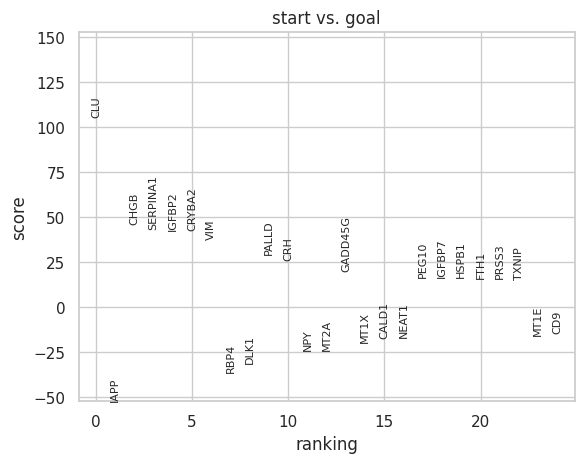

View of AnnData object with n_obs × n_vars = 10000 × 500
    obs: 'donor_id', 'cell_type', 'assay', 'sex', 'age', 'race', 'disease_state', 'cell_disease', 'n_genes', 'state', 'batch'
    var: 'n_cells'
    obsm: 'X_umap'

In [8]:


num_samples = 5000
target=0.0
top_n_var=500
start_state.obs['state']="start"
goal_state.obs['state']="goal"
start_state_c=start_state.copy()
goal_state_c=goal_state.copy()
#sc.pp.filter_cells(start_state_c, min_genes=100)
#sc.pp.filter_cells(goal_state_c, min_genes=100)
start_indices = np.random.choice(start_state_c.n_obs, size=min(start_state_c.n_obs,goal_state_c.n_obs,num_samples), replace=False)
goal_indices = np.random.choice(goal_state_c.n_obs, size=min(start_state_c.n_obs,goal_state_c.n_obs,num_samples), replace=False)
combined_adata=merge_adata(start_state[start_indices,:].copy(),deepcopy(preprocessed_start),goal_state[goal_indices,:].copy(),deepcopy(preprocessed_goal),target)
sc.pp.filter_genes(combined_adata, min_cells=100,inplace=True)

checkpoint=combined_adata.copy()



print(checkpoint.shape)

sc.pp.normalize_total(checkpoint)
# Logarithmize the data
sc.pp.log1p(checkpoint)
sc.pp.highly_variable_genes(checkpoint, n_top_genes=top_n_var)
selection=checkpoint.var.highly_variable.copy()
checkpoint=checkpoint[:, checkpoint.var.highly_variable]
group_a="start"
group_b="goal"


sc.tl.rank_genes_groups(checkpoint, groupby='state', groups=[group_a], reference=group_b, method='t-test', use_raw=False,rankby_abs=True,key_added="ab")
sc.pl.rank_genes_groups(checkpoint, n_genes=25, sharey=False,key="ab")
basic_dge = extract_rank_genes_groups(checkpoint, key='ab', n_genes=None)
basic_dge['absolute_scores']=basic_dge['scores_ab'].abs()


checkpoint=combined_adata.copy()
checkpoint=checkpoint[:, selection]


checkpoint_safe=checkpoint.copy()
checkpoint

In [9]:

import scDesign3Py
import os
import multiprocessing
stime=time.time()
# Get the number of available CPU cores
num_cores = os.cpu_count()

# Use all cores except one
cores_to_use = max(num_cores - 1, 1)
#cores_to_use =10

test = scDesign3Py.scDesign3(return_py=True)
test.set_r_random_seed(123)
bpparam = scDesign3Py.get_bpparam(mode="MulticoreParam", show=False)
const_data = test.construct_data(
    anndata=checkpoint,
    default_assay_name="X",
    celltype='state',
    corr_formula='state'
)
#

marginal = test.fit_marginal(
    data=const_data,
    mu_formula='state',
    sigma_formula='state',
    usebam=False,
    family_use="nb",
    n_cores=cores_to_use,
    parallelization="bpmapply",
    bpparam=bpparam
)


copula = test.fit_copula(
    input_data=const_data['dat'],
    marginal_dict=marginal,
    copula="gaussian",
    family_use='nb',
    return_py=True,
    n_cores=cores_to_use,
    parallelization="bpmapply",
    bpparam=bpparam,
)
para = test.extract_para(
    marginal_dict=marginal,
    data=const_data["dat"],
    new_covariate=None,
)

print(time.time()-stime)

The R project used is located at /usr/lib/R


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 4: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write t

286.0715434551239


In [10]:
basic_dge.sort_values('absolute_scores')

,gene,scores_ab,logfoldchange,pval,pval_adj,group,absolute_scores
499,CUZD1,-0.005481,-0.000810,0.995627,0.995627,start,0.005481
498,TTC23,-0.021761,-0.008009,0.982639,0.984609,start,0.021761
497,RHPN2,-0.025418,-0.010390,0.979722,0.983657,start,0.025418
496,REG3A,-0.045868,-0.010420,0.963416,0.969232,start,0.045868
495,TGFBR2,0.053753,0.012520,0.957133,0.964852,start,0.053753
...,...,...,...,...,...,...,...
4,IGFBP2,42.823383,3.773367,0.000000,0.000000,start,42.823383
3,SERPINA1,43.037266,2.975446,0.000000,0.000000,start,43.037266
2,CHGB,46.282574,1.612523,0.000000,0.000000,start,46.282574
1,IAPP,-52.134808,-4.180646,0.000000,0.000000,start,52.134808


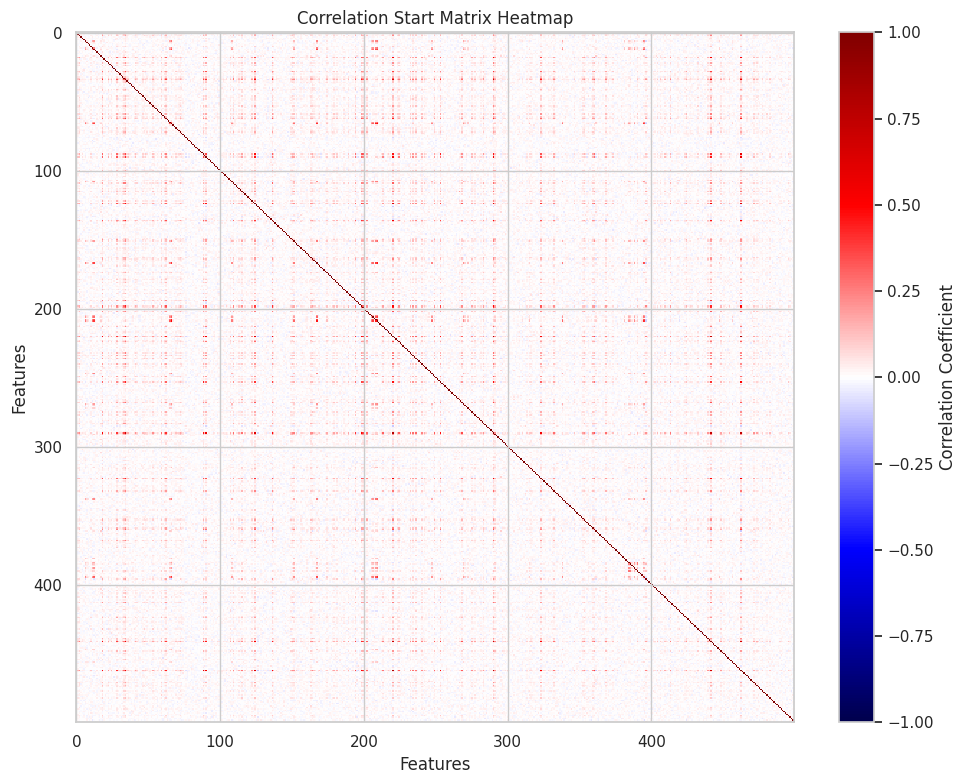

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm

# Simulating a large 1000x1000 correlation matrix
np.random.seed(42)
corr_matrix = np.random.rand(1000, 1000) * 2 - 1  # Generate values between -1 and 1

# Create a custom colormap with 0 mapped to gray
cmap = plt.get_cmap('seismic')  # Diverging colormap
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)  # Center 0 to gray

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size for large matrices
heatmap = plt.imshow(copula['copula_list']['start'], cmap=cmap, norm=norm, aspect='auto', interpolation='nearest')
plt.colorbar(heatmap, label='Correlation Coefficient')
plt.title("Correlation Start Matrix Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")

plt.tight_layout()
plt.show()

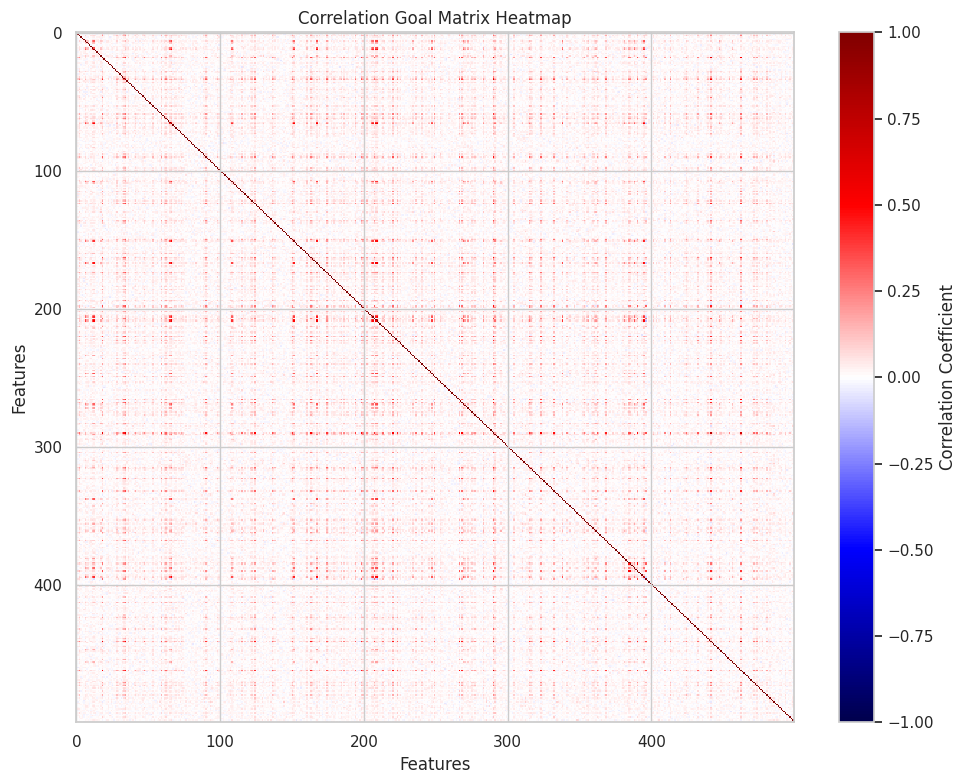

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm

# Simulating a large 1000x1000 correlation matrix
np.random.seed(42)
corr_matrix = np.random.rand(1000, 1000) * 2 - 1  # Generate values between -1 and 1

# Create a custom colormap with 0 mapped to gray
cmap = plt.get_cmap('seismic')  # Diverging colormap
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)  # Center 0 to gray

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size for large matrices
heatmap = plt.imshow(copula['copula_list']['goal'], cmap=cmap, norm=norm, aspect='auto', interpolation='nearest')
plt.colorbar(heatmap, label='Correlation Coefficient')
plt.title("Correlation Goal Matrix Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")

plt.tight_layout()
plt.show()

In [13]:


def cell_dropout(adata, dropout_percentage, gene_dropout_probs):
    """
    Apply dropout to each cell based on a given dropout percentage and cell-specific, gene-specific dropout probabilities.

    Parameters:
    - adata: AnnData object
    - dropout_percentage: Percentage (float) of genes to randomly drop per cell
    - gene_dropout_probs: 2D array of dropout probabilities per gene per cell (shape = num_cells x num_genes)

    Returns:
    - Modified AnnData object with dropout applied
    """
    if dropout_percentage > 0:
        # Ensure dropout_percentage is a valid number between 0 and 1
        if not (0 <= dropout_percentage <= 1):
            raise ValueError("dropout_percentage must be between 0 and 1.")
        
        # Ensure gene_dropout_probs has the correct shape (num_cells x num_genes)
        if gene_dropout_probs.shape != adata.X.shape:
            raise ValueError("gene_dropout_probs shape must match the shape of adata.X.")
        
        # Normalize dropout probabilities for each cell (if needed)
        # This step ensures that the values are valid probabilities between 0 and 1. If they are already probabilities, this can be skipped.
        gene_dropout_probs = np.clip(gene_dropout_probs, 0, 1)
        
        # Loop through each cell
        for cell_idx in range(adata.X.shape[0]):
            # Calculate how many genes to drop for this cell based on dropout_percentage
            num_genes_to_dropout = int(adata.X.shape[1] * dropout_percentage)
            
            # For this cell, sample which genes to drop based on the gene-specific dropout probabilities
            # We use np.random.choice to select genes based on the probabilities for this particular cell (gene_dropout_probs[cell_idx])
            genes_to_drop = np.random.choice(
                adata.X.shape[1], 
                num_genes_to_dropout, 
                replace=False, 
                p=gene_dropout_probs.iloc[cell_idx, :]
            )
            
            # Set the values of the selected genes to zero in this cell
            adata.X[cell_idx, genes_to_drop] = 0
    
    return adata

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group start starts

R[write to console]: Sample Copula group goal starts



0.925096


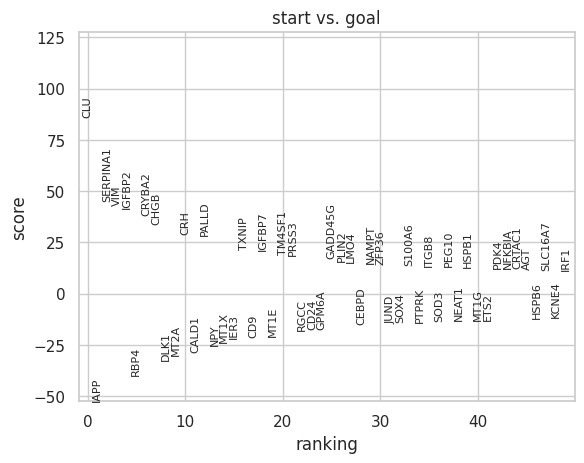

AnnData object with n_obs × n_vars = 9959 × 500
    obs: 'state', 'n_genes'
    uns: 'log1p', 'ab'

In [14]:


simu_new = test.simu_new(
    mean_mat=para["mean_mat"],
    sigma_mat=para["sigma_mat"],
    copula_dict=copula["copula_list"],
    #input_data=const_data["dat"],
    #new_covariate=const_data["newCovariate"],
    important_feature='all',#list(para["mean_mat"].columns.isin(basic_dge.sort_values('absolute_scores').tail(boost_set)['gene'])),#'all',#copula["important_feature"],
    #filtered_gene=const_data["filtered_gene"],
    n_cores=10,
    parallelization="bpmapply",
    bpparam=bpparam,
    family_use='nb'
)
checkpoint=sc.AnnData(X=simu_new.to_numpy().copy(),
          obs=const_data["newCovariate"],
          var=pd.DataFrame(index=simu_new.columns,
                          ))
sc.pp.filter_cells(checkpoint, min_genes=10)
sc.pp.normalize_total(checkpoint)
sc.pp.log1p(checkpoint)
# 3. Fit MaxAbsScaler on train
scaler = MaxAbsScaler()
X_train = checkpoint.X
checkpoint.X[:,:] = scaler.fit_transform(X_train)
#checkpoint=checkpoint[:,checkpoint.X.max(axis=0)!=0]
#sc.pp.scale(checkpoint, zero_center=False)
#checkpoint.X = (checkpoint.X) / (checkpoint.X.max(axis=0))

print(np.count_nonzero(simu_new == 0)/simu_new.size)
sc.tl.rank_genes_groups(checkpoint, groupby='state', groups=[group_a], reference=group_b, method='t-test', use_raw=False,rankby_abs=True,key_added="ab")
sc.pl.rank_genes_groups(checkpoint, n_genes=50, sharey=False,key="ab")


min_zero_inflation = np.count_nonzero(simu_new == 0)/simu_new.size
checkpoint

In [15]:
to_export=para.copy()
to_export['covariate']=const_data['newCovariate']


with open(main_path+single_cell_data+'/sim_parameters.pkl', 'wb') as f:
    pickle.dump(to_export, f)


In [16]:
def printer(gen,current_mat='sigma_mat'):
    print(gen)
    print(para[current_mat][const_data["newCovariate"]['state']=="start"][gen].head(1).values)
    print(para[current_mat][const_data["newCovariate"]['state']=="goal"][gen].head(1).values)
    print(current_mat)
    print()

printer("FTH1","sigma_mat")
printer("PALLD","sigma_mat")
printer("CLU","sigma_mat")

printer("FTH1","mean_mat")
printer("PALLD","mean_mat")
printer("CLU","mean_mat")


FTH1
[1.39508203]
[1.69770376]
sigma_mat

PALLD
[3.68803906]
[4.3281774]
sigma_mat

CLU
[1.89549437]
[3.47715781]
sigma_mat

FTH1
[23.7968]
[25.0404]
mean_mat

PALLD
[1.5386]
[0.316]
mean_mat

CLU
[25.444]
[2.7684]
mean_mat



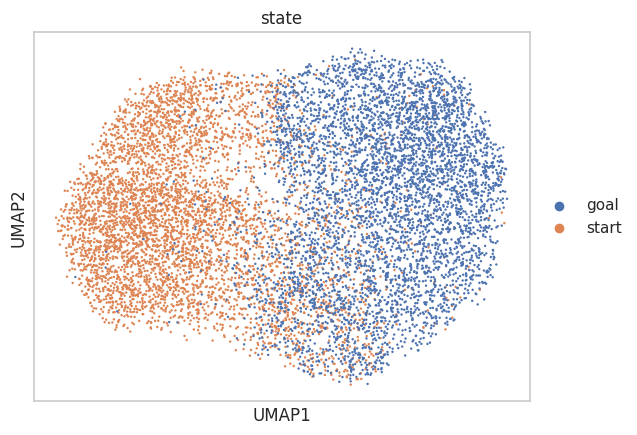

In [17]:

sc.tl.pca(checkpoint,n_comps=100, svd_solver='arpack')
sc.pl.pca_variance_ratio(checkpoint, log=True)
sc.pp.neighbors(checkpoint, n_neighbors=10, n_pcs=50)
sc.tl.leiden(checkpoint, resolution=0.5,n_iterations=2,flavor="igraph")
sc.tl.umap(checkpoint)
clear_output()
sc.pl.umap(checkpoint, color=['state'])

In [18]:
import pandas as pd

# Assuming 'checkpoint' is already loaded in your environment:
# Extract UMAP coordinates and state labels
umap_array = checkpoint.obsm['X_umap']
state_series = checkpoint.obs['state']

# Build the DataFrame
df = pd.DataFrame({
    'umap1': umap_array[:, 0],
    'umap2': umap_array[:, 1],
    'state': state_series.values
})

# Save to CSV
output_filename = f'{main_path}{outdir}/alphatobetaUMAP.csv'
df.to_csv(output_filename, index=False)

print(f"DataFrame with UMAP coordinates and states saved to '{output_filename}'.")


DataFrame with UMAP coordinates and states saved to '/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/nbonlyrealistic_simulation_alpha_to_beta/alphatobetaUMAP.csv'.


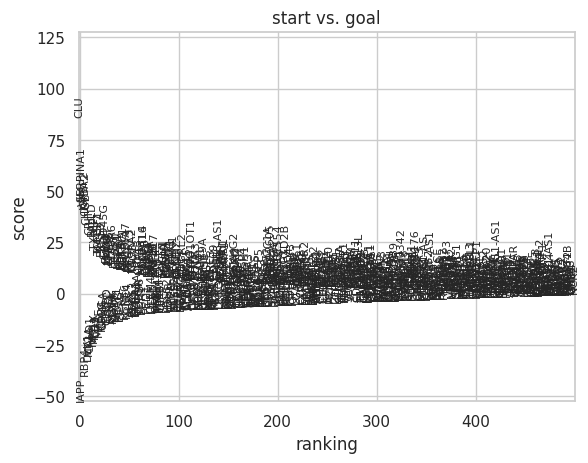

In [19]:

sc.tl.rank_genes_groups(checkpoint, groupby='state', groups=[group_a], reference=group_b, method='t-test', use_raw=False,rankby_abs=True,key_added="ab")
sc.pl.rank_genes_groups(checkpoint, n_genes=500, sharey=False,key="ab")

In [20]:

'''
def zero_prop(array):
    proportion_zeroes = (array == 0).sum(axis=0) / array.shape[0]
    return(proportion_zeroes)

print("Proportion of zeros for each column:", )

info=pd.DataFrame({
'start_means':start_means.iloc[0,:],
'start_dispersion':start_sigmas.iloc[0,:],
'start_zeroes':start_zeroes.iloc[0,:],
'goal_means':goal_means.iloc[0,:],
'goal_dispersion':goal_sigmas.iloc[0,:],
'goal_zeroes':goal_zeroes.iloc[0,:],
'start_zero_proportion':zero_prop(checkpoint[checkpoint.obs['state']=='start'].X),
'goal_zero_proportion':zero_prop(checkpoint[checkpoint.obs['state']=='goal'].X)
})

def convert_params(mean, dispersion):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://mathworld.wolfram.com/NegativeBinomialDistribution.html
    """

    n=(mean**2)/(mean+(dispersion*(mean**2)))
    p = n/(n+mean)
    #print(n,p)
    return n, p
n2,p2=convert_params(info['goal_means'],info['goal_dispersion'])
n1,p1=convert_params(info['start_means'],info['start_dispersion'])
info['goal_n']=n2
info['start_n']=n1
info['goal_p']=p2
info['start_p']=p1

info['score']=((p1+p2)/2)
info['genes']=info.index
#info['score']=info['goal_dispersion']*info['goal_means']+info['start_dispersion']*info['start_means']
#info['score']=info['goal_dispersion']+info['start_dispersion']
info[info['start_p']>info['start_n']].sort_values("score").head(50)
#info[info['genes']=="C11orf96"]

'''

'\ndef zero_prop(array):\n    proportion_zeroes = (array == 0).sum(axis=0) / array.shape[0]\n    return(proportion_zeroes)\n\nprint("Proportion of zeros for each column:", )\n\ninfo=pd.DataFrame({\n\'start_means\':start_means.iloc[0,:],\n\'start_dispersion\':start_sigmas.iloc[0,:],\n\'start_zeroes\':start_zeroes.iloc[0,:],\n\'goal_means\':goal_means.iloc[0,:],\n\'goal_dispersion\':goal_sigmas.iloc[0,:],\n\'goal_zeroes\':goal_zeroes.iloc[0,:],\n\'start_zero_proportion\':zero_prop(checkpoint[checkpoint.obs[\'state\']==\'start\'].X),\n\'goal_zero_proportion\':zero_prop(checkpoint[checkpoint.obs[\'state\']==\'goal\'].X)\n})\n\ndef convert_params(mean, dispersion):\n    """\n    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports\n\n    See https://mathworld.wolfram.com/NegativeBinomialDistribution.html\n    """\n\n    n=(mean**2)/(mean+(dispersion*(mean**2)))\n    p = n/(n+mean)\n    #print(n,p)\n    return n, p\nn2,p2=convert_params(info[\'goal_means

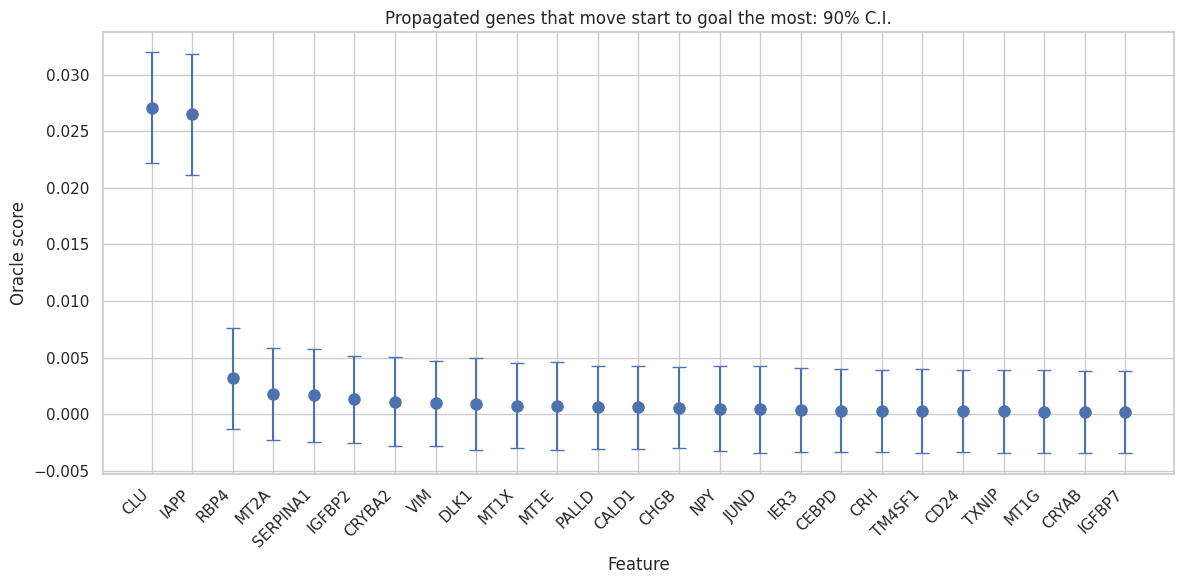

In [21]:

simulation_results={}
min_layer_size_star=int(checkpoint.shape[1]*1/4)
max_layer_size_star=int(checkpoint.shape[1]*2/4)


min_layer_size_oracle=int(checkpoint.shape[1]*1/4)
max_layer_size_oracle=int(checkpoint.shape[1]*2/4)

min_layer_size_prop=int(checkpoint.shape[1]*1/4)
max_layer_size_prop=int(checkpoint.shape[1]*2/4)



from copy import deepcopy


category_labels=['state']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
simu_new = test.simu_new(
    mean_mat=para["mean_mat"],
    sigma_mat=para["sigma_mat"],
    copula_dict=copula["copula_list"],
    input_data=const_data["dat"],
    new_covariate=const_data["newCovariate"],
    important_feature='all',#list(para["mean_mat"].columns.isin(basic_dge.sort_values('absolute_scores').tail(boost_set)['gene'])),#'all',#copula["important_feature"],
    filtered_gene=const_data["filtered_gene"],
    n_cores=10,
    parallelization="bpmapply",
    bpparam=bpparam,
    family_use='nb'
)
checkpoint=sc.AnnData(X=simu_new.to_numpy().copy(),
          obs=const_data["newCovariate"],
          var=pd.DataFrame(index=simu_new.columns,
                          ))
sc.pp.filter_genes(checkpoint, min_cells=3)
sc.pp.filter_cells(checkpoint, min_genes=10)

sc.pp.normalize_total(checkpoint)
sc.pp.log1p(checkpoint)
#selected = checkpoint.var.index.copy()
#checkpoint=checkpoint[:,checkpoint.X.max(axis=0)!=0]
#sc.pp.scale(checkpoint, zero_center=False)
#checkpoint.X = (checkpoint.X) / (checkpoint.X.max(axis=0))
group_a="start"
group_b="goal"

one_hot_labels, num_categories = gosip.one_hot_encode_combinations(checkpoint.obs, ['state'])
checkpoint.one_hot_labels= one_hot_labels
checkpoint.one_hot_labels

checkpoint_backup=deepcopy(checkpoint)

###########################################################################################
###########################################################################################
#### Stargan
###########################################################################################
###########################################################################################         
study = optuna.create_study(storage="sqlite:///"+outdir+"/"+single_cell_data.replace(" ","_")+"_SIMULATION_stargan_nb.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=single_cell_data.replace(" ", "_")+"_stargan_SIMULATION_"+"zero_inflation_"+str(target)+"_main.db",
                            load_if_exists=True)


start_time=time.time()
if len(study.get_trials())<hyperparam_trials:
    study.optimize(lambda trial: opt_objective_stargan(trial, checkpoint,num_categories=num_categories,hyperparam_epochs=hyperparam_epochs,validation_ratio=validation_ratio,min_layer_size=min_layer_size_star,max_layer_size=max_layer_size_star,burn_in=burn_in, bsize=bsize,zi=zi), n_trials=hyperparam_trials-len(study.get_trials()))

# Get the best hyperparameters
best_params = study.best_params

stargan_hyperparam = {
    'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes_generator': [
        best_params["gen_layer0"],
        best_params["gen_layer1"],
        best_params["gen_layer2"]
    ],
    'layer_nodes_discriminator': [
        best_params["disc_layer0"],
        best_params["disc_layer1"],
        best_params["disc_layer2"]
    ],
    'critics': 3,#best_params["critics"],
#"lambda_adv":best_params["lambda_adv"],
#"lambda_cls":best_params["lambda_cls"],
#"lambda_rec":best_params["lambda_rec"],
#"lambda_iden":best_params["lambda_iden"],
    "dropout_rate":best_params["dropout_rate"]
}
'''
stargan_hyperparam = {
    'batch_size': 512,
    'learning_rate': 0.001,
    'layer_nodes_generator': [
        250,
        100,
        250
    ],
    'layer_nodes_discriminator': [
        250,
        125,
        250
    ],
    'critics': 3,
"lambda_adv":1,
"lambda_cls":1,
"lambda_rec":10,
"lambda_iden":1,
"lambda_sink":1,
    "dropout_rate":0.1
}


'''
###########################################################################################
###########################################################################################
#### Oracle
###########################################################################################
###########################################################################################


study = optuna.create_study(storage="sqlite:///"+outdir+"/"+single_cell_data.replace(" ","_")+"_SIMULATION_oracle_nb.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=single_cell_data.replace(" ", "_")+"_oracle_SIMULATION_"+"zero_inflation_"+str(target)+"_main.db",
                            load_if_exists=True)

start_time=time.time()
if len(study.get_trials())<hyperparam_trials:
    study.optimize(lambda trial: opt_objective_oracle(trial, checkpoint,num_categories=num_categories,hyperparam_epochs=hyperparam_epochs,validation_ratio=validation_ratio,min_layer_size=min_layer_size_oracle,max_layer_size=max_layer_size_oracle,burn_in=burn_in, bsize=bsize), n_trials=hyperparam_trials-len(study.get_trials()))
print(time.time()-start_time)
# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)
oracle_hyperparam = {'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes': [
        best_params["disc_layer0"],
        best_params["disc_layer1"],
        best_params["disc_layer2"]
    ],
    'dropout_rate_d': best_params['disc_dropout_rate']
}
'''

oracle_hyperparam = {'batch_size': 512,
    'learning_rate': 0.001,
    'layer_nodes': [
        200,
        150,
        100
    ],
    'dropout_rate_d': 0.1
}
'''       
###########################################################################################
###########################################################################################
#### Propagator
###########################################################################################
###########################################################################################

study = optuna.create_study(storage="sqlite:///"+outdir+"/"+single_cell_data.replace(" ","_")+"_SIMULATION_propagator_nb.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=single_cell_data.replace(" ", "_")+"_propagator_SIMULATION_"+"zero_inflation_"+str(target)+"_main.db",
                            load_if_exists=True)

start_time=time.time()
if len(study.get_trials())<hyperparam_trials:
    study.optimize(lambda trial: opt_objective_propagator(trial, checkpoint,num_categories=num_categories,hyperparam_epochs=hyperparam_epochs,validation_ratio=validation_ratio,min_layer_size=min_layer_size_prop,max_layer_size=max_layer_size_prop,burn_in=burn_in, bsize=bsize,zi=zi), n_trials=hyperparam_trials-len(study.get_trials()))
print(time.time()-start_time)
# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

propagator_hyperparam = {
    'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes_generator': [
        best_params["gen_layer0"],
        best_params["gen_layer1"],
        best_params["gen_layer2"]
    ],
    'dropout_rate_g': best_params['gen_dropout_rate'],
    'latent_dim':best_params['latent'],
    'beta':float(best_params['beta'])
    
}

'''
propagator_hyperparam = {
    'batch_size': 512,
    'learning_rate': 0.001,
    'layer_nodes_generator': [
        250,
        100,
        250
    ],
    'dropout_rate_g': 0.1,
    'latent_dim':50,
    'beta':10.0
}
'''
shared_filter = None
filter_criteria_start = ["start"]
filter_criteria_goal  = ["goal"]
print(target)

for run in range(runs):
    substring_to_save= f'run_{run}'
    if substring_to_save not in simulation_results:
        attempts = 0
        success = False
        max_attempts=1
        while attempts < max_attempts and not success:
            try:
                checkpoint=deepcopy(checkpoint_backup)
                train_adata,val_adata=  split_and_maxabs_scale_adata(checkpoint,validation_ratio)
                #################################################
                ###Refit models with new zero-inflation
                #################################################
                loss_weights=[1,1,10,10]
                stargan = gosip.StarGAN(input_dim=checkpoint.shape[1],
                                 num_domains=[checkpoint.one_hot_labels.shape[1]],
                                 device = device,
                                 learning_rate = stargan_hyperparam['learning_rate'],
                                 layer_g = stargan_hyperparam['layer_nodes_generator'],
                                 layer_d = stargan_hyperparam['layer_nodes_discriminator'],
                                 critics = stargan_hyperparam['critics'],
                                  lambda_adv=loss_weights[0],
                                  lambda_cls=loss_weights[1],
                                  lambda_rec=loss_weights[2],
                                  #lambda_iden=loss_weights[3],
                                  #lambda_sink=loss_weights[4],
                                 dropout_rate=stargan_hyperparam["dropout_rate"],
                                       zi=zi)
                

                train_dataloader = gosip.prepare_data(train_adata,num_categories,batch_size=stargan_hyperparam["batch_size"])
                val_dataloader = gosip.prepare_data(val_adata,num_categories,batch_size=stargan_hyperparam["batch_size"])
                stargan.train( dataloader=train_dataloader,val_loader=val_dataloader, num_epochs=num_epochs,patience=patience,burn_in=burn_in,verbose=True)
                stargan.G.eval()
                stargan.D.eval()
                torch.cuda.empty_cache()
                
                oracle = gosip.Oracle(input_dim=checkpoint.shape[1],
                         num_domains=num_categories,
                         device = device,
                         learning_rate = oracle_hyperparam['learning_rate'],
                         layer_d = oracle_hyperparam['layer_nodes'],
                         drpt_d = oracle_hyperparam['dropout_rate_d'])
                train_dataloader = gosip.prepare_data(train_adata,num_categories,batch_size=oracle_hyperparam["batch_size"])
                val_dataloader = gosip.prepare_data(val_adata,num_categories,batch_size=oracle_hyperparam["batch_size"])
                oracle.train(dataloader=train_dataloader, val_loader=val_dataloader, num_epochs=num_epochs,patience=patience,burn_in=burn_in,verbose=True,optuna_run=False)
                oracle.D.eval()
                torch.cuda.empty_cache()
                train_dataloader = gosip.prepare_data(train_adata,num_categories,batch_size=propagator_hyperparam["batch_size"])
                val_dataloader = gosip.prepare_data(val_adata,num_categories,batch_size=propagator_hyperparam["batch_size"])
                propagator = gosip.Propagator(input_dim=train_adata.shape[1],
                                 num_domains=num_categories,
                                 device = device,
                                 learning_rate = propagator_hyperparam['learning_rate'],
                                 layer_g = propagator_hyperparam['layer_nodes_generator'],
                                 drpt_g = propagator_hyperparam['dropout_rate_g'],
                                 latent_dim=propagator_hyperparam['latent_dim'],zi=zi)
                loss_fn = gosip.BtcvaeLoss(n_data=train_adata.shape[0], alpha=1.0, beta=propagator_hyperparam['beta'], gamma=1.0,zi=zi)
                propagator.train(dataloader=train_dataloader, val_loader=val_dataloader,
                                 num_epochs=num_epochs,patience=patience,burn_in=burn_in, verbose=True,optuna_run=False,
                                 loss_fn=loss_fn)

                
            
                propagator.G.eval()
                torch.cuda.empty_cache()
                sc.tl.rank_genes_groups(checkpoint, groupby='state', groups=[group_a], reference=group_b, method='t-test', use_raw=False,rankby_abs=True,key_added="ab")
                sc.pl.rank_genes_groups(checkpoint, n_genes=25, sharey=False,key="ab")
                # 1. Concatenate the AnnData objects (this aligns var‐axes, etc.)
                processed_checkpoint = anndata.concat(
                    [train_adata, val_adata],
                    join='inner',            # only keep genes present in both
                    label='split',           # name of the new obs column
                    keys=['train', 'val'],   # values in combined_adata.obs['split']
                    fill_value=0
                )
                
                # 2. Stitch the one_hot_labels together
                combined_labels = pd.concat(
                    [train_adata.one_hot_labels, val_adata.one_hot_labels],
                    axis=0
                )
                
                # 3. Re‐order them to match the new obs order, then attach back
                combined_labels = combined_labels.reindex(processed_checkpoint.obs_names)
                processed_checkpoint.one_hot_labels = combined_labels.copy()
                perturbation_metrics,accuracy,result_path=gosip.full_report(adata=processed_checkpoint,
                                                          stargan=stargan,
                                                          oracle=oracle,
                                                          propagator=propagator,
                                                          shared_filter=shared_filter,
                                                          filter_criteria_start=filter_criteria_start,
                                                          filter_criteria_goal=filter_criteria_goal,
                                                          main_path=main_path,outdir=outdir,top_n=25,percentile=0,
                                                          umap=False,oracle_performance=True,alpha=0.5,
                                                          sample_fraction=0.1,
                                                          num_categories=num_categories,
                                                          category_labels=category_labels,
                                                          device = device,apply_fdr=False)
        
                
            
                success=True
            except Exception as e:
                print(f"Attempt {attempts + 1} failed with error: {e}")
            finally:
                attempts += 1
        if not success:
            print(f"Failed to check the key in the dictionary after {max_attempts} attempts.")

        dst_dir = os.path.dirname(result_path)               # strip off the filename
        os.makedirs(dst_dir, exist_ok=True)                  # create all missing directories
        copy_tree(result_path, os.path.dirname(result_path[:-1])+"/"+substring_to_save)
        simulation_results[substring_to_save]=perturbation_metrics
        simulation_results[substring_to_save]['sample_size']=checkpoint.shape[0]
        with open(f"{main_path}{outdir}/result_dictionary.pkl", "wb") as f:
            pickle.dump(simulation_results, f)

    clear_output(wait=True)



In [22]:
perturbation_metrics.sort_values('out_degree_pagerank_positive')

,in_degree_pagerank_positive,out_degree_pagerank_positive,oracle_score,suggested_perturbation,label,oracle_score_pval,k,sample_size
gene_name,,,,,,,,
EPS8,1.000000,1.000000,0.000001,0.003618,EPS8,9.209219e-01,1,9961
CPM,1.004401,1.000000,-0.000013,-0.016624,CPM,9.785771e-01,1,9961
SLC16A7,1.030586,1.000000,0.000061,-0.005828,SLC16A7,2.829017e-01,1,9961
NDUFA4L2,1.999847,1.000000,-0.000047,-0.005987,NDUFA4L2,8.960155e-03,1,9961
IGFBP6,1.002395,1.000000,-0.000018,-0.017565,IGFBP6,6.067156e-01,1,9961
...,...,...,...,...,...,...,...,...
SERPINA1,1.446799,74.293871,0.001667,-0.160245,SERPINA1,2.079896e-61,1,9961
MT2A,1.154356,150.349978,0.001772,0.302587,MT2A,1.452017e-66,1,9961
CLU,1.259661,182.300060,0.027067,-0.616644,CLU,0.000000e+00,1,9961


In [23]:

simulation_results.keys()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Call the function


organized_results={}
data_frames_to_merge = []
result_names=[]
for run in range(runs):
    #print(run)
    result_name=f'run_{run}'
    
    temp_df=simulation_results[result_name].copy()
    #print(temp_df.shape)
    direction=True
    temp_df["zero_inflation"]=target
    #temp_df['odecp_rank_quantile']=pd.qcut(temp_df["out_degree_pagerank_positive"].rank(), 5, labels=False) + 1
    #temp_df['idecp_rank_quantile']=pd.qcut(temp_df["in_degree_pagerank_positive"].rank(), 5, labels=False) + 1
    #temp_df['oracle_score_rank_quantile']=pd.qcut(temp_df["oracle_score"].rank(), 5, labels=False) + 1
    temp_df['odecp_rank']=temp_df["out_degree_pagerank_positive"].rank(ascending= direction)
    temp_df['idecp_rank']=temp_df["in_degree_pagerank_positive"].rank(ascending= direction)
    temp_df['oracle_score_rank']=temp_df["oracle_score"].rank(ascending= direction)
    #temp_df['odcp_rank']=temp_df["out_degree_centrality_positive"].rank(ascending= direction)
    #temp_df['idcp_rank']=temp_df["in_degree_centrality_positive"].rank(ascending= direction)       
    temp_df['both']=(temp_df["oracle_score"].rank(ascending= direction)+temp_df["out_degree_pagerank_positive"].rank(ascending= direction))/2
    #temp_df = detect_elbow_and_classify(temp_df, rank_column='oracle_score_rank', metric_column='oracle_score',elbow_column_name='oracle_top_set')
    #temp_df = detect_elbow_and_classify(temp_df, rank_column='idecp_rank', metric_column='in_degree_pagerank_positive',elbow_column_name='idecp_top_set')
    #temp_df = detect_elbow_and_classify(temp_df, rank_column='odecp_rank', metric_column='out_degree_pagerank_positive',elbow_column_name='odecp_top_set')

    temp_df['run']=run

    data_frames_to_merge.append(temp_df)    
organized_results=pd.concat(data_frames_to_merge)
#organized_results=organized_results[organized_results['oracle_score']>=0]
#bigger rank is better       

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_gene_auc_with_ci_top(dataframe, label_col, score_col, zero_col, percentile=98, max_unique_colors=10, colormap='tab10'):
    """
    Plots the average score versus zero inflation for each gene, highlights genes with top AUCs,
    and includes 95% confidence intervals. Top percentile genes are assigned unique colors (up to `max_unique_colors`).

    Parameters:
        dataframe (pd.DataFrame): The input data containing the columns for grouping, scores, and zero inflation.
        label_col (str): Column name for labels (e.g., gene identifiers).
        score_col (str): Column name for scores (e.g., centrality measure).
        zero_col (str): Column name for zero inflation values.
        percentile (float): Percentile threshold to highlight top AUC genes. Default is 98.
        max_unique_colors (int): Maximum number of unique colors for top genes. Default is 10.
        colormap (str): Name of the colormap to use from plt.colormaps.
    """
    # Group by label and zero inflation, calculate the mean score and standard error
    grouped = dataframe.groupby([label_col, zero_col])
    mean_scores = grouped[score_col].mean().reset_index()
    sem_scores = grouped[score_col].sem().reset_index()  # Standard error of the mean

    # Merge mean and standard error for easy plotting
    merged = mean_scores.merge(sem_scores, on=[label_col, zero_col], suffixes=('_mean', '_sem'))

    # Compute the area under the curve (AUC) for each label
    auc_values = {}
    for label in merged[label_col].unique():
        label_data = merged[merged[label_col] == label]
        auc = np.trapz(label_data[f"{score_col}_mean"], label_data[zero_col])  # Calculate AUC using trapezoidal rule
        auc_values[label] = auc

    # Determine the specified percentile of AUC
    auc_percentile_threshold = np.percentile(list(auc_values.values()), percentile)

    # Get top genes based on AUC
    top_genes = sorted(auc_values.items(), key=lambda x: x[1], reverse=True)[:max_unique_colors]
    top_gene_labels = [gene for gene, _ in top_genes]

    # Create the colormap
    cmap = plt.colormaps[colormap]
    colors = [cmap(i / max_unique_colors) for i in range(max_unique_colors)]
    color_map = {gene: colors[i % max_unique_colors] for i, gene in enumerate(top_gene_labels)}

    # Initialize the plot
    plt.figure(figsize=(12, 6))

    # Plot each label's data with 95% CI
    for label, auc in auc_values.items():
        label_data = merged[merged[label_col] == label]
        mean = label_data[f"{score_col}_mean"]
        sem = label_data[f"{score_col}_sem"]
        zero_vals = label_data[zero_col]

        ci_upper = mean + 1.96 * sem  # 95% CI upper bound
        ci_lower = mean - 1.96 * sem  # 95% CI lower bound

        if label not in top_gene_labels:  # Highlight top genes
            plt.plot(zero_vals, mean, marker='o', color='black', alpha=0.1,linestyle='dashed')

    for label, auc in auc_values.items():
        label_data = merged[merged[label_col] == label]
        mean = label_data[f"{score_col}_mean"]
        sem = label_data[f"{score_col}_sem"]
        zero_vals = label_data[zero_col]

        ci_upper = mean + 1.96 * sem  # 95% CI upper bound
        ci_lower = mean - 1.96 * sem  # 95% CI lower bound

        if label in top_gene_labels:  # Highlight top genes        
            color = color_map[label]
            plt.plot(zero_vals, mean, marker='o', label=f"{label} (AUC: {auc:.2f})", color=color)
            plt.fill_between(zero_vals, ci_lower, ci_upper, color=color, alpha=0.1)
            
    # Add labels, legend, and grid
    plt.title("Average Score vs Zero Inflation for Each Label (with 95% CI)")
    plt.xlabel(zero_col)
    plt.ylabel("Average " + score_col)
    plt.legend(title="Label", loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_gene_auc_with_ci(dataframe, label_col, score_col, zero_col,tocolor, percentile=98, max_unique_colors=10, colormap='tab10'):
    """
    Plots the average score versus zero inflation for each gene, highlights genes with top AUCs,
    and includes 95% confidence intervals. Top percentile genes are assigned unique colors (up to `max_unique_colors`).

    Parameters:
        dataframe (pd.DataFrame): The input data containing the columns for grouping, scores, and zero inflation.
        label_col (str): Column name for labels (e.g., gene identifiers).
        score_col (str): Column name for scores (e.g., centrality measure).
        zero_col (str): Column name for zero inflation values.
        percentile (float): Percentile threshold to highlight top AUC genes. Default is 98.
        max_unique_colors (int): Maximum number of unique colors for top genes. Default is 10.
        colormap (str): Name of the colormap to use from plt.colormaps.
    """
    # Group by label and zero inflation, calculate the mean score and standard error
    grouped = dataframe.groupby([label_col, zero_col])
    mean_scores = grouped[score_col].mean().reset_index()
    sem_scores = grouped[score_col].sem().reset_index()  # Standard error of the mean

    # Merge mean and standard error for easy plotting
    merged = mean_scores.merge(sem_scores, on=[label_col, zero_col], suffixes=('_mean', '_sem'))

    # Compute the area under the curve (AUC) for each label
    auc_values = {}
    for label in merged[label_col].unique():
        label_data = merged[merged[label_col] == label]
        auc = np.trapz(label_data[f"{score_col}_mean"], label_data[zero_col])  # Calculate AUC using trapezoidal rule
        auc_values[label] = auc

    # Determine the specified percentile of AUC
    auc_percentile_threshold = np.percentile(list(auc_values.values()), percentile)

    # Get top genes based on AUC
    top_genes = tocolor#sorted(auc_values.items(), key=lambda x: x[1], reverse=True)[:max_unique_colors]
    top_gene_labels = tocolor#[gene for gene, _ in top_genes]
    
    # Create the colormap
    cmap = plt.colormaps[colormap]
    colors = [cmap(i / max_unique_colors) for i in range(max_unique_colors)]
    color_map = {gene: colors[i % max_unique_colors] for i, gene in enumerate(top_gene_labels)}

    # Initialize the plot
    plt.figure(figsize=(12, 6))

    # Plot each label's data with 95% CI
    for label, auc in auc_values.items():
        label_data = merged[merged[label_col] == label]
        mean = label_data[f"{score_col}_mean"]
        sem = label_data[f"{score_col}_sem"]
        zero_vals = label_data[zero_col]

        ci_upper = mean + 1.96 * sem  # 95% CI upper bound
        ci_lower = mean - 1.96 * sem  # 95% CI lower bound

        if label not in top_gene_labels:  # Highlight top genes
            plt.plot(zero_vals, mean, marker='o', color='black', alpha=0.1,linestyle='dashed')

    for label, auc in auc_values.items():
        label_data = merged[merged[label_col] == label]
        mean = label_data[f"{score_col}_mean"]
        sem = label_data[f"{score_col}_sem"]
        zero_vals = label_data[zero_col]

        ci_upper = mean + 1.96 * sem  # 95% CI upper bound
        ci_lower = mean - 1.96 * sem  # 95% CI lower bound

        if label in top_gene_labels:  # Highlight top genes        
            color = color_map[label]
            plt.plot(zero_vals, mean, marker='o', label=f"{label} (AUC: {auc:.2f})", color=color)
            plt.fill_between(zero_vals, ci_lower, ci_upper, color=color, alpha=0.1)
            
    # Add labels, legend, and grid
    plt.title("Average Score vs Zero Inflation for Each Label (with 95% CI)")
    plt.xlabel(zero_col)
    plt.ylabel("Average " + score_col)
    plt.legend(title="Label", loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(False)
    plt.tight_layout()
    plt.show()


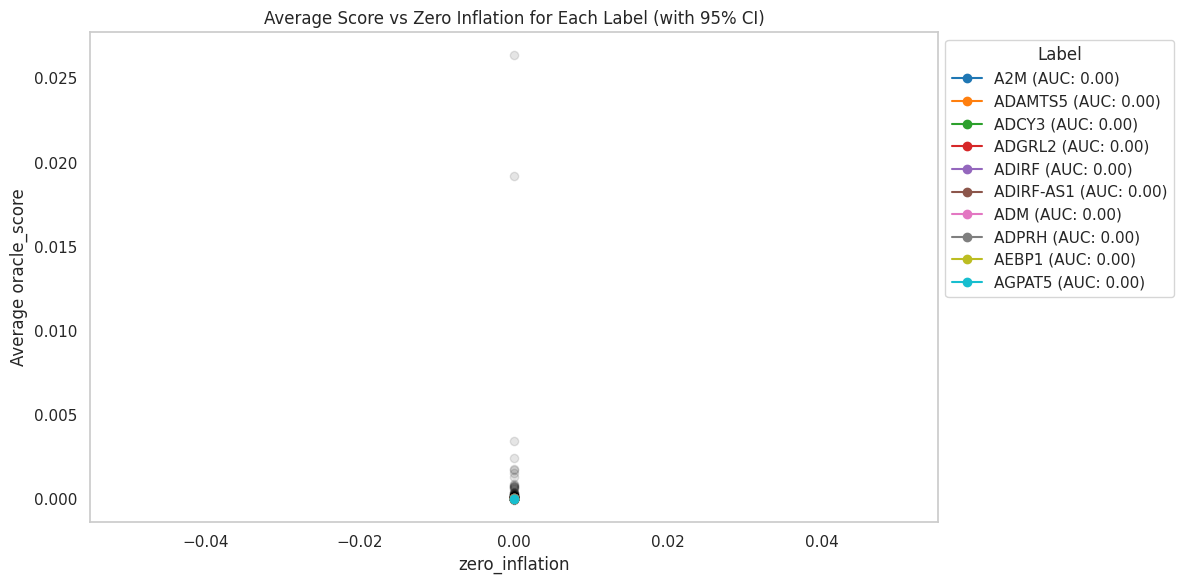

In [26]:
plot_gene_auc_with_ci_top(
    dataframe=organized_results,
    label_col='label',
    score_col='oracle_score',
    zero_col='zero_inflation'
)

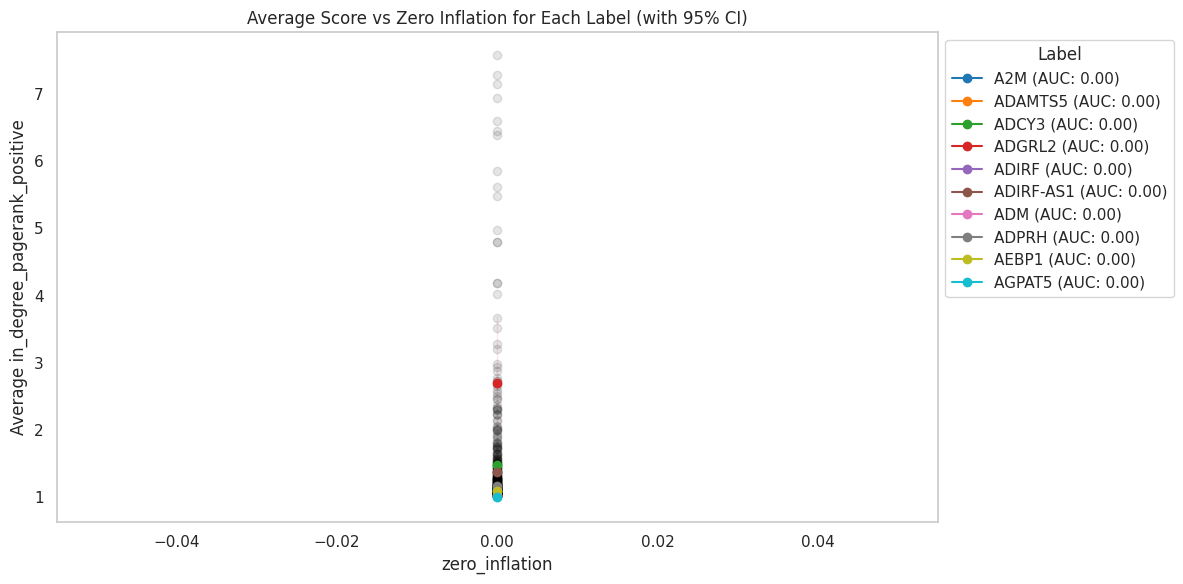

In [27]:
plot_gene_auc_with_ci_top(
    dataframe=organized_results,
    label_col='label',
    score_col='in_degree_pagerank_positive',
    zero_col='zero_inflation'
)

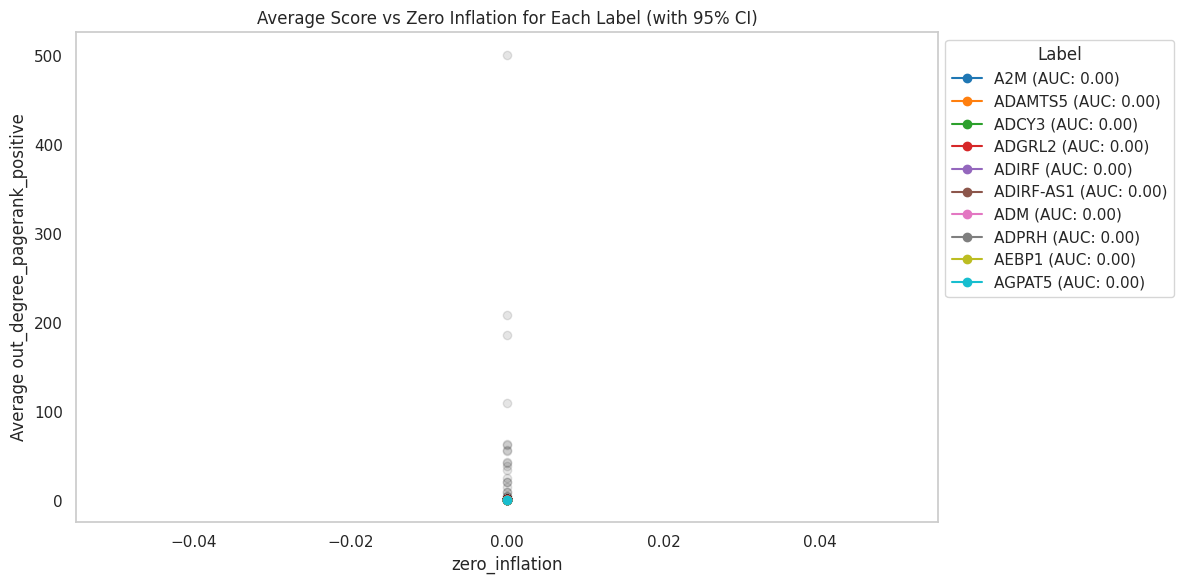

In [28]:
plot_gene_auc_with_ci_top(
    dataframe=organized_results,
    label_col='label',
    score_col='out_degree_pagerank_positive',
    zero_col='zero_inflation'
)

In [29]:
'''
info=pd.DataFrame({
'start_means':start_means.iloc[0,:],
'start_dispersion':start_sigmas.iloc[0,:],
'start_zeroes':start_zeroes.iloc[0,:],
'goal_means':goal_means.iloc[0,:],
'goal_dispersion':goal_sigmas.iloc[0,:],
'goal_zeroes':goal_zeroes.iloc[0,:]})

def convert_params(mean, dispersion):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://mathworld.wolfram.com/NegativeBinomialDistribution.html
    """

    n=(mean**2)/(mean+(dispersion*(mean**2)))
    p = n/(n+mean)
    #print(n,p)
    return n, p
n2,p2=convert_params(info['goal_means'],info['goal_dispersion'])
n1,p1=convert_params(info['start_means'],info['start_dispersion'])
info['score']=(p1+p2)/2

#info['score']=info['goal_dispersion']*info['goal_means']+info['start_dispersion']*info['start_means']
#info['score']=info['goal_dispersion']+info['start_dispersion']
info.sort_values("score").head(20)
'''

'\ninfo=pd.DataFrame({\n\'start_means\':start_means.iloc[0,:],\n\'start_dispersion\':start_sigmas.iloc[0,:],\n\'start_zeroes\':start_zeroes.iloc[0,:],\n\'goal_means\':goal_means.iloc[0,:],\n\'goal_dispersion\':goal_sigmas.iloc[0,:],\n\'goal_zeroes\':goal_zeroes.iloc[0,:]})\n\ndef convert_params(mean, dispersion):\n    """\n    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports\n\n    See https://mathworld.wolfram.com/NegativeBinomialDistribution.html\n    """\n\n    n=(mean**2)/(mean+(dispersion*(mean**2)))\n    p = n/(n+mean)\n    #print(n,p)\n    return n, p\nn2,p2=convert_params(info[\'goal_means\'],info[\'goal_dispersion\'])\nn1,p1=convert_params(info[\'start_means\'],info[\'start_dispersion\'])\ninfo[\'score\']=(p1+p2)/2\n\n#info[\'score\']=info[\'goal_dispersion\']*info[\'goal_means\']+info[\'start_dispersion\']*info[\'start_means\']\n#info[\'score\']=info[\'goal_dispersion\']+info[\'start_dispersion\']\ninfo.sort_values("score").head(20)\n

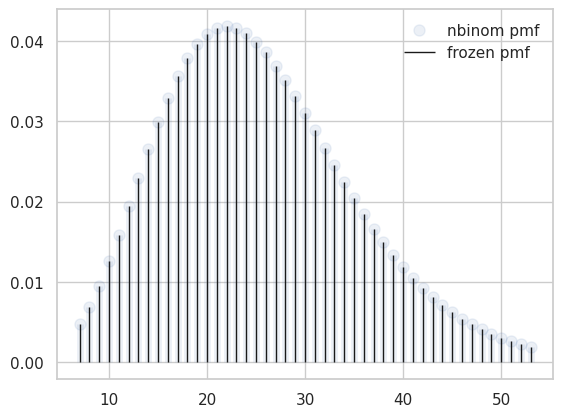

In [30]:
import numpy as np
from scipy.stats import nbinom
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
mean=25.444000		

dispersion=100.44
n,p=convert_params(mean, dispersion)
rv = nbinom(n, p)
x = np.arange(nbinom.ppf(0.01, n, p),
              nbinom.ppf(0.99, n, p))
ax.plot(x, nbinom.pmf(x, n, p), 'bo', ms=8, label='nbinom pmf',alpha=0.1)
ax.vlines(x, 0, nbinom.pmf(x, n, p), colors='b', lw=5, alpha=0.1)

rv = nbinom(n, p)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
        label='frozen pmf')
ax.legend(loc='best', frameon=False)
plt.show()

In [31]:
plot_gene_auc_with_ci(
    dataframe=organized_results,
    label_col='label',
    score_col='out_degree_pagerank_positive',
    zero_col='zero_inflation',
    tocolor=corr_df.columns
    )
corr_df 

NameError: name 'corr_df' is not defined

In [ ]:
plot_gene_auc_with_ci_top(
    dataframe=organized_results,
    label_col='label',
    score_col='in_degree_pagerank_positive',
    zero_col='zero_inflation'
)
corr_df 

In [ ]:
plot_gene_auc_with_ci(
    dataframe=organized_results,
    label_col='label',
    score_col='oracle_score',
    zero_col='zero_inflation',
    tocolor=corr_df.columns
)

In [ ]:
stargan_hyperparam
oracle_hyperparam
propagator_hyperparam